In [2]:
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

from torchvision import transforms

from torch import nn, optim

In [18]:
t_trans = transforms.Compose([
#     transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

class OneHotImages(Dataset):
    def __init__(self, file_path, transforms=None):
        self.file_path = file_path

        # Images
        self.files = os.listdir(os.path.join(file_path, "img"))
        
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = torch.load(os.path.join(self.file_path, "img", self.files[idx]))

        with open(
            os.path.join(self.file_path, "labels", self.files[idx][:-3] + ".txt")
        ) as fp:
            label = float(fp.read())
        # Omit the tree class
        
        if self.transforms is not None:
            img = self.transforms(img[:, :, [0, 1, 3]])
        else:
            img = img[:, :, [0,1,3]]
        return img, torch.tensor(label, dtype=torch.float)

In [19]:
train = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/train", transforms = t_trans)
test = OneHotImages("/datacommons/carlsonlab/zdc6/cs590/land_use/test")

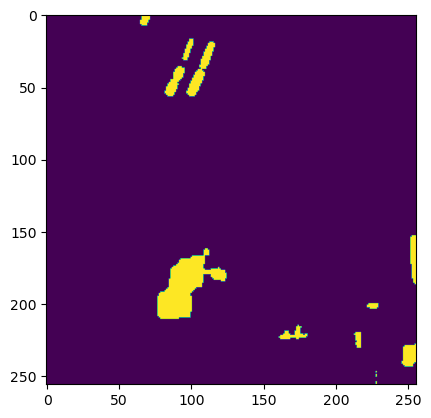

In [40]:
example = train[0]
plt.imshow(example[0][:, :, 0])

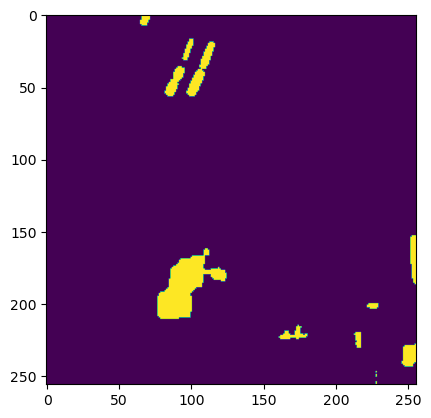

In [47]:
plt.imshow(example[0][:, :, 0])

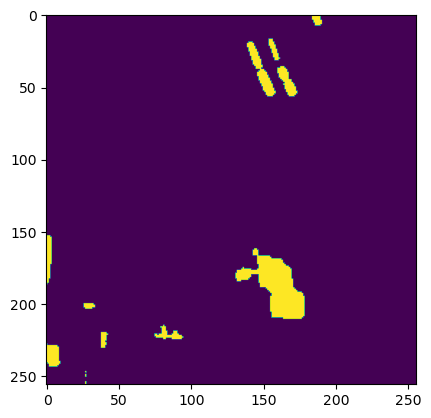

In [124]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.intercept = 75.91 #nn.Parameter(torch.tensor(78.))

        self.weight = nn.Parameter(torch.randn(256, 256, 3))
        
        self.softplus = nn.Softplus()
        
        torch.nn.init.uniform_(self.weight, a = 0.00001, b = 0.0001)
        
        self.to('cuda')
    def forward(self, X):
        return self.intercept + (F.relu(self.weight) * X).sum(axis=(1,2,3))


In [125]:
model = SimpleModel()

In [126]:
train_loader = DataLoader(train, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

In [127]:
w_opt = torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=3e3)
# i_opt = torch.optim.AdamW([model.intercept], lr=1)

In [128]:
model.intercept

75.91

In [129]:
for epoch in range(10):
    print(f"Epoch {epoch}")

    train_loss = 0
    count = 0
    model.train()
    for X, y in train_loader:
        X = X.to('cuda')
        y = y.to('cuda')

        w_opt.zero_grad()
#         i_opt.zero_grad()
        
        y_hat = model(X)
        loss = F.mse_loss(y_hat, y)  + 0.01 * model.weight.abs().sum()

        loss.backward()

        w_opt.step()
#         i_opt.step()
        
        train_loss += loss.item() * X.size(0)
        count += X.size(0)
        
    print(f"Train loss: {train_loss / count}")
    model.eval()
    test_loss = 0
    count = 0
    for X, y in test_loader:
        X = X.to('cuda')
        y = y.to('cuda')

        y_hat = model(X)
        loss = F.mse_loss(y_hat, y)
        
        test_loss += loss.item() * X.size(0)
        count += X.size(0)
        
    print(f"Test loss: {test_loss / count}")

Epoch 0
Train loss: 6.102385383103276
Test loss: 2.8352699960981096
Epoch 1
Train loss: 2.916464502322433
Test loss: 2.80430541423537
Epoch 2
Train loss: 2.9832594331342026
Test loss: 2.767301743074974
Epoch 3
Train loss: 2.7583020154018585
Test loss: 2.6963564994172278
Epoch 4
Train loss: 2.708002205229464
Test loss: 2.6884896547898003
Epoch 5
Train loss: 2.6614172027924363
Test loss: 2.66839305362346
Epoch 6
Train loss: 2.6268255072116347
Test loss: 2.6591047322527963
Epoch 7
Train loss: 2.5997773410156606
Test loss: 2.6503244364483756
Epoch 8
Train loss: 2.577352934765385
Test loss: 2.6440347484920337
Epoch 9
Train loss: 2.55890106065367
Test loss: 2.6388709411858033


In [131]:
model.weight.abs().sum()

tensor(20.1601, device='cuda:0', grad_fn=<SumBackward0>)

-0.06896476441684629


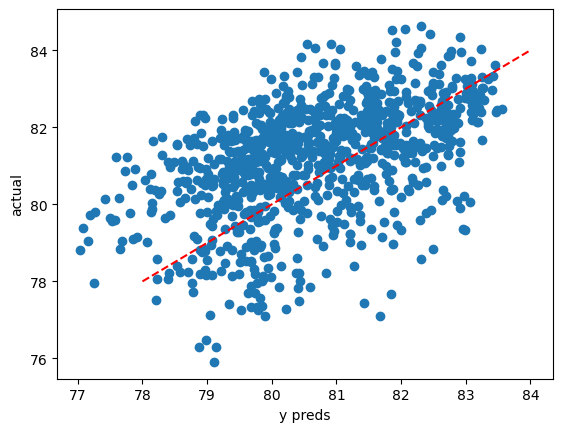

In [130]:
y_preds = []
y_actual = []
with torch.no_grad():
    for X, y in train_loader:
        X = X.to('cuda')
        y_actual.extend(y.numpy())

        y_hat = model(X)
        y_preds.extend(y_hat.cpu().numpy())
        
print(r2_score(y_actual, y_preds))

plt.scatter(y_preds, y_actual)
plt.plot(np.linspace(78, 84, 2), np.linspace(78, 84, 2), 'r--')
plt.xlabel("y preds")
plt.ylabel("actual")
plt.show()

0.271123866548064


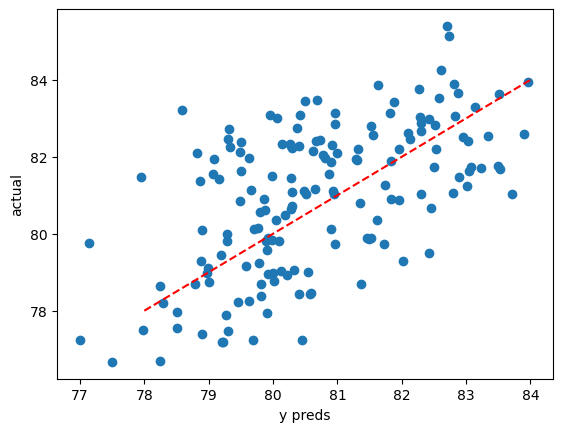

In [132]:
# Look at test results
y_preds = []
y_actual = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to('cuda')
        y_actual.extend(y.numpy())

        y_hat = model(X)
        y_preds.extend(y_hat.cpu().numpy())
    
print(r2_score(y_actual, y_preds))
plt.scatter(y_preds, y_actual)
plt.plot(np.linspace(78, 84, 2), np.linspace(78, 84, 2), 'r--')
plt.xlabel("y preds")
plt.ylabel("actual")
plt.show()

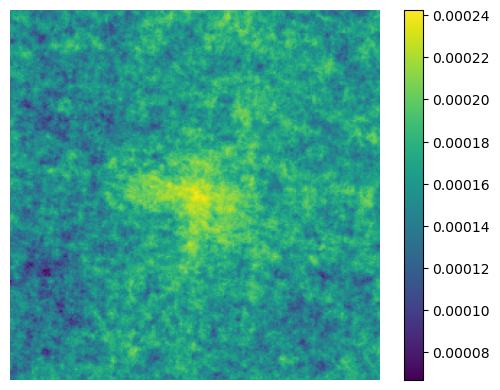

In [134]:
# Let's visualize the weights
plt.imshow(F.relu(model.weight[:, :, 0]).cpu().detach().numpy())
plt.axis(False)
plt.colorbar()
plt.show()

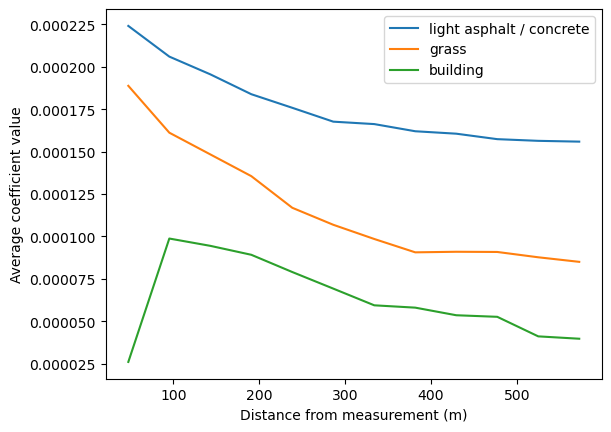

In [135]:
# Lastly, let's see if we can look at the effect over distance using these sets of weights.
# This loop iterates through the three classes and calculates the weights for ~50 meter concentric circles
# at a time (e.g., the first circle is a 50m radius around the middle, and the second contains the weights
# from 50 to 100m from the center)

for i in range(3):
    # Calculate the weights
    weights = F.relu(model.weight[:, :, i]).cpu().detach().numpy()
    rad = 10
    results = []
    x_axis = []
    while rad < 128:
        arr = np.zeros((256, 256))
        cx, cy = 128, 128

        radius = rad
        y, x = np.ogrid[:256, :256]
        dist_from_center = np.sqrt((x - cx)**2 + (y - cy)**2)
        arr[((dist_from_center <= radius) & (radius - 10 < dist_from_center))] = 1

        effect = np.mean(weights[arr == 1])
        x_axis.append(rad * 4.77)
        results.append(effect)
        rad = rad + 10
        
    if i == 0:
        label = 'light asphalt / concrete'
    elif i == 1:
        label = 'grass'
    elif i == 2:
        label = 'building'
    plt.plot(x_axis, results, label=label)
        
plt.legend()
plt.xlabel("Distance from measurement (m)")
plt.ylabel("Average coefficient value")
plt.show()

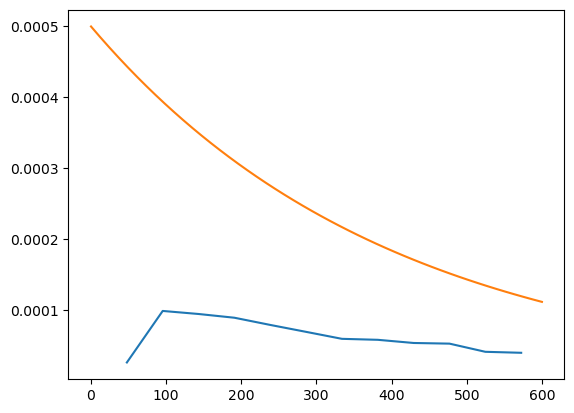

In [136]:
plt.plot(x_axis, results, label=str(i))
x = np.linspace(0, 600)
plt.plot(x, 0.0005*np.exp(-x / 400))

# Let's look at some very simple linear models
Essentially, I want to see if the percentage of each land value can be used.

In [49]:
X_train_s = []
y_train_s = []
for X, y in train_loader:
    X_train_s.append(X[0].numpy().mean(axis=(0,1)))
    y_train_s.append(y[0].item())
    
    
X_test_s = []
y_test_s = []
for X, y in test_loader:
    X_test_s.append(X[0].numpy().mean(axis=(0,1)))
    y_test_s.append(y[0].item())
    

In [50]:
X_train_s = np.array(X_train_s)
X_test_s = np.array(X_test_s)

In [51]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train_s, y_train_s)

LinearRegression()

In [52]:
preds = lm.predict(X_test_s)

In [53]:
r2_score(y_test_s, preds)

-0.5315205474861704

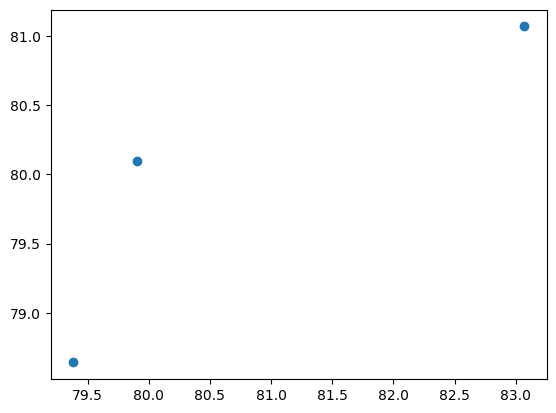

In [54]:
plt.scatter(preds, y_test_s)

In [55]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train_s, y_train_s)

preds = dt.predict(X_test_s)

r2_score(y_test_s, preds)

-0.07215218305038595

In [56]:
lm.coef_

array([ 7.73432411,  0.75977462, 22.03406328])

In [57]:
lm.intercept_

77.69789611782032

In [58]:
plt.imshow(X[0,:, :, 3].cpu().numpy())

IndexError: index 3 is out of bounds for dimension 3 with size 3

In [176]:
len(y_actual)

941

In [177]:
model.intercept

Parameter containing:
tensor(78.9949, device='cuda:0', requires_grad=True)